In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/umnmobillistrik/mobil_listrik.csv


In [2]:
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
import nltk
import re
import string
import plotly.graph_objects as go
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import optuna
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, clone, ClassifierMixin
from sklearn.svm import LinearSVC, SVC


2024-09-02 16:51:49.443160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 16:51:49.443335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 16:51:49.635956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/umnmobillistrik/mobil_listrik.csv")

In [4]:
data.head(5)

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif


In [5]:
data.sentimen.nunique()

3

In [6]:
data.isna().sum()

id_komentar      0
nama_akun        1
tanggal          0
text_cleaning    2
sentimen         0
dtype: int64

In [7]:
data.dtypes

id_komentar      object
nama_akun        object
tanggal          object
text_cleaning    object
sentimen         object
dtype: object

In [8]:
data.describe()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
count,1517,1516,1517,1515,1517
unique,1517,1515,1514,1514,3
top,Ugzbll5eyrIy3-gdUUJ4AaABAg,Albert,2023-06-06 14:02:09+00:00,mahal,negatif
freq,1,2,2,2,869


In [9]:
data.nunique()

id_komentar      1517
nama_akun        1515
tanggal          1514
text_cleaning    1514
sentimen            3
dtype: int64

In [10]:
positif_sentimen = data[data['sentimen'] == 'positif'].shape[0]
negatif_sentimen = data[data['sentimen'] == 'negatif'].shape[0]
netral_sentimen = data[data['sentimen'] == 'netral'].shape[0]

In [11]:
sentimen = [netral_sentimen,positif_sentimen,negatif_sentimen]
labels = ['Netral', 'Positif', 'Negatif']
colors = ['#ff9999', '#66b3ff', '#99ff99']

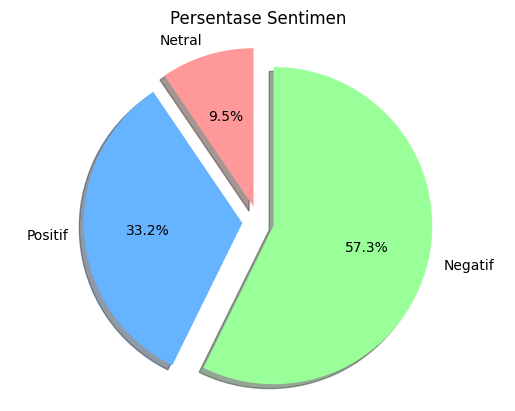

In [12]:
fig, ax = plt.subplots()
ax.pie(sentimen, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=[0.1, 0.1, 0.1], shadow=True)
    
plt.title('Persentase Sentimen')
plt.axis('equal')
plt.show()

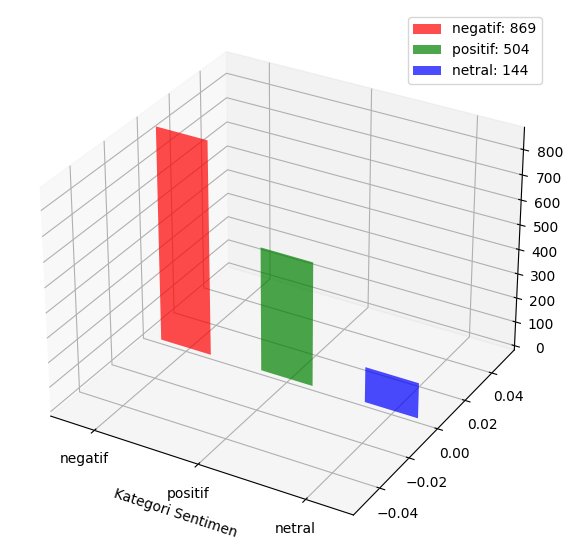

In [13]:
sentiment_counts = data['sentimen'].value_counts()

categories = sentiment_counts.index
counts = sentiment_counts.values
x_pos = np.arange(len(categories))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
bars = ax.bar(x_pos, counts, zdir='y', width=0.5, color=colors, alpha=0.7)

legend_labels = [f'{category}: {count}' for category, count in zip(categories, counts)]
ax.legend(bars, legend_labels, loc='best')

ax.set_xlabel('Kategori Sentimen')

ax.set_xticks(x_pos)
ax.set_xticklabels(categories)
plt.show()


### Ekstraksi Fitur

In [14]:
data['text_cleaning'] = data['text_cleaning'].astype(str)
data['pemisah_kata'] = data.text_cleaning.apply(lambda x:re.findall(r'\w+', x ))
data['total_kata'] = data.pemisah_kata.apply(len)
data['tanggal'] = pd.to_datetime(data['tanggal'])
data['jam'] = data.tanggal.apply(lambda x: x.hour)
data['bulan'] = data.tanggal.apply(lambda x: x.month)
data['tahun'] = data.tanggal.apply(lambda x: x.year)

In [15]:
data.dtypes

id_komentar                   object
nama_akun                     object
tanggal          datetime64[ns, UTC]
text_cleaning                 object
sentimen                      object
pemisah_kata                  object
total_kata                     int64
jam                            int64
bulan                          int64
tahun                          int64
dtype: object

## Sentiment Distribution

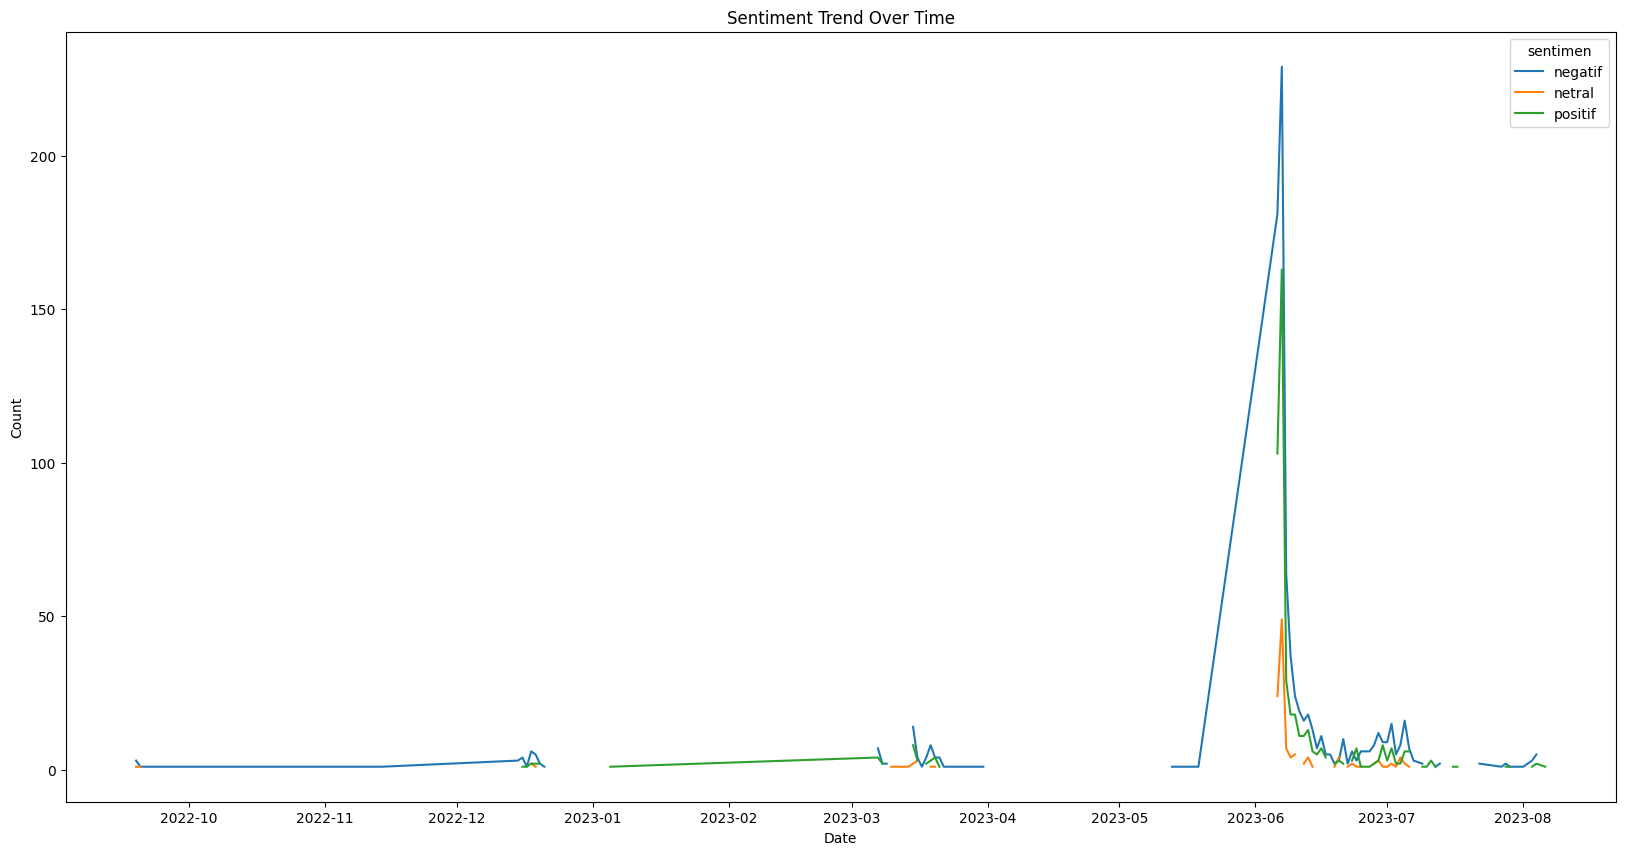

In [16]:
sentiment_trend = data.groupby(data['tanggal'].dt.date)['sentimen'].value_counts().unstack()

plt.figure(figsize=(20, 10))
sentiment_trend.plot(ax=plt.gca())
plt.title('Sentiment Trend Over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.show()

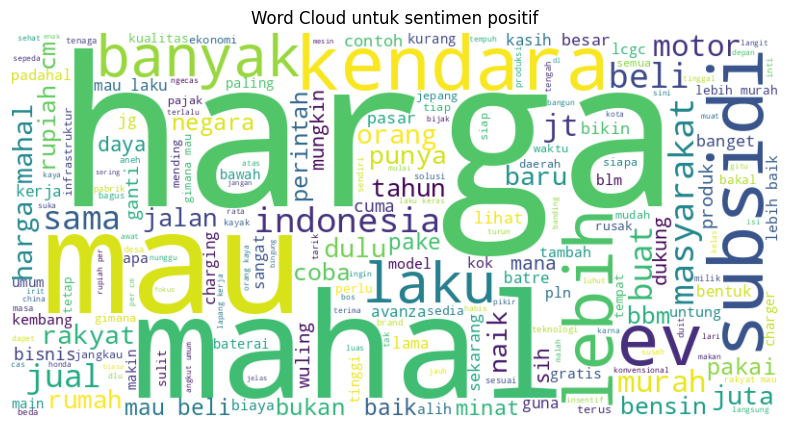

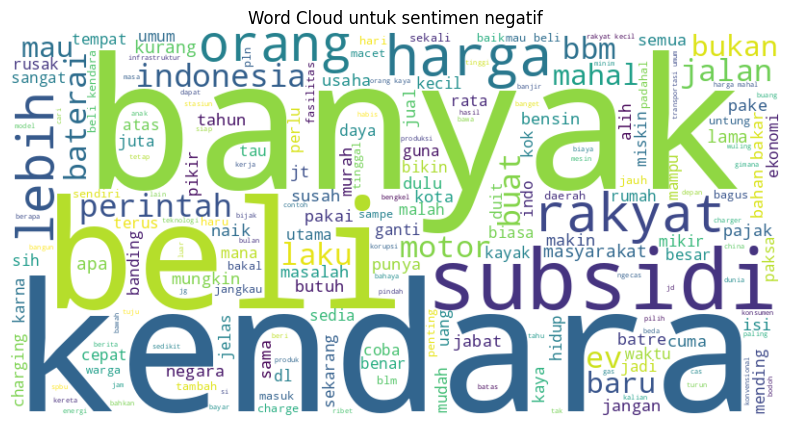

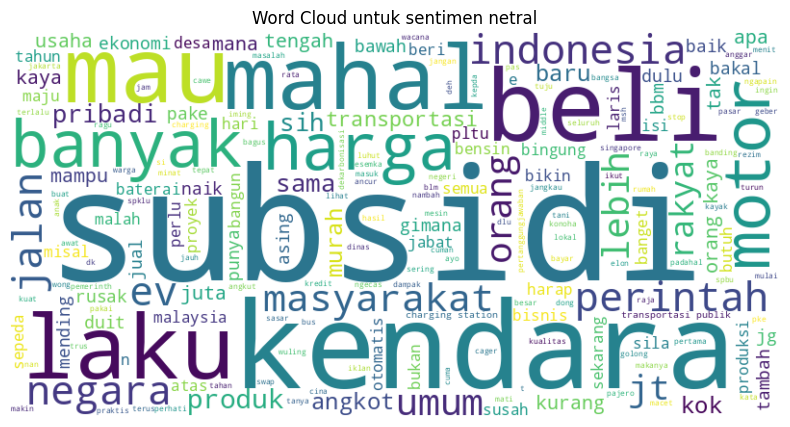

In [17]:
from wordcloud import WordCloud
for sentiment in data['sentimen'].unique():
    text = ' '.join(data[data['sentimen'] == sentiment]['text_cleaning'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud untuk sentimen {sentiment}')
    plt.axis('off')
    plt.show()


In [18]:
# n-gram analysis (bigrams)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(data['text_cleaning'])
bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_bigrams = bigrams.sum().sort_values(ascending=False).head(20)

In [19]:
top_bigrams_df = top_bigrams.reset_index()
top_bigrams_df.columns = ['Bigram', 'Total']

In [20]:
fig_bigrams = px.treemap(top_bigrams_df, path=['Bigram'], values='Total', 
                         title='Top 20 Bigrams',
                         color='Total',
                         color_continuous_scale='Blues')

fig_bigrams.show()


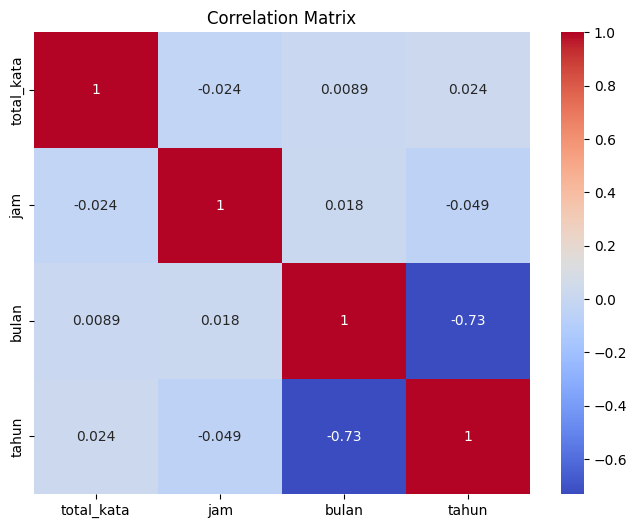

In [21]:
correlation_matrix = data[['total_kata', 'jam', 'bulan', 'tahun']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

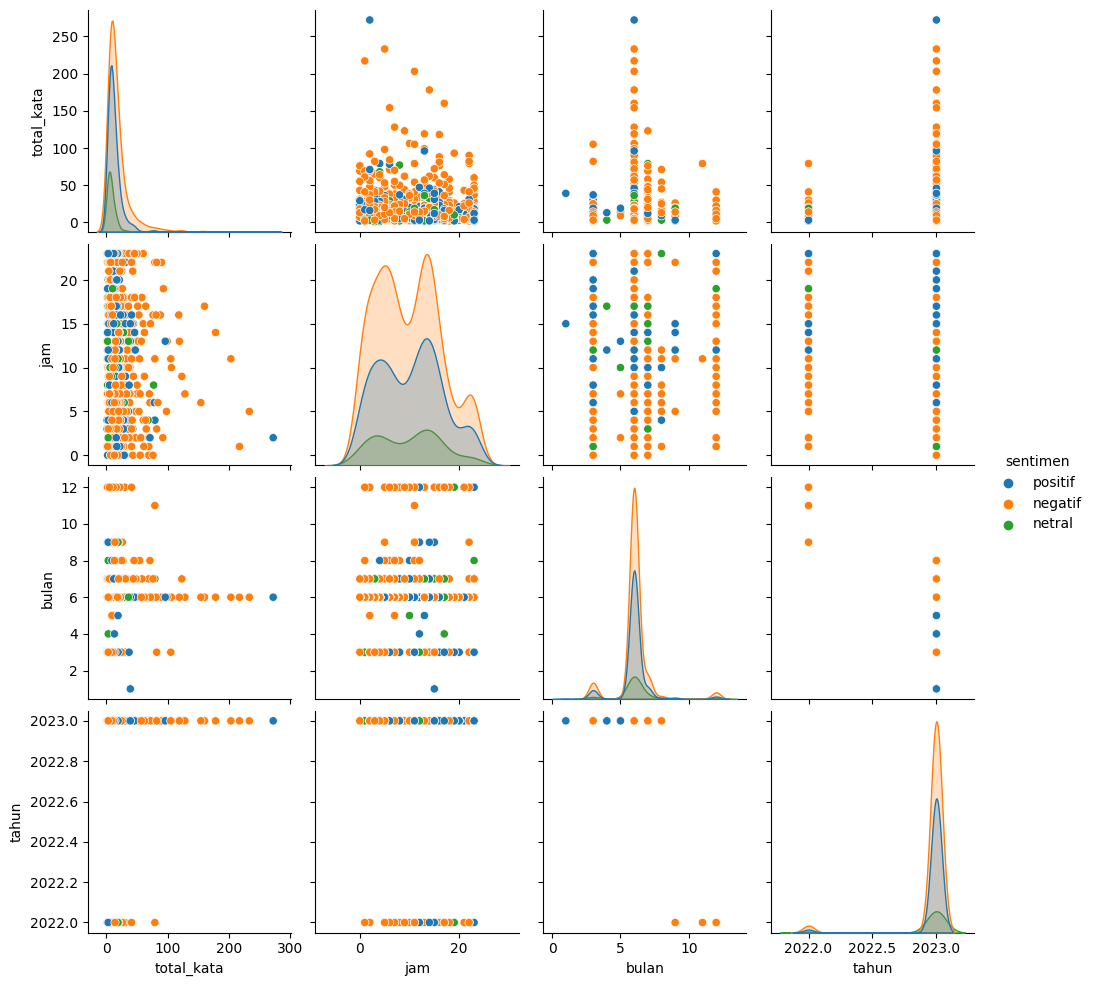

In [22]:
sns.pairplot(data[['total_kata', 'jam', 'bulan', 'tahun', 'sentimen']], hue='sentimen')
plt.show()


## Total Most Common Words dalam Data

In [23]:
top = Counter([item for sublist in data['pemisah_kata'] for item in sublist])
temp_list = pd.DataFrame(top.most_common(30))
temp_list.columns = ['Kata', 'Total']
temp_list.style.background_gradient(cmap='Purples')

,Kata,Total
0,harga,446
1,beli,325
2,kendara,305
3,subsidi,288
4,mau,269
5,mahal,256
6,banyak,239
7,lebih,237
8,ev,217
9,rakyat,201


In [24]:
fig = px.bar(temp_list, x="Total", y="Kata", title='Kata yang sering digunakan', orientation='h', 
             width=700, height=700,color='Kata')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [25]:
fig = px.treemap(temp_list, path=['Kata'], values='Total', 
                 title='Kata yang sering digunakan',
                 color='Total',
                 color_discrete_sequence=['purple'])
fig.update_layout(paper_bgcolor='white', plot_bgcolor='white')
fig.show()

In [26]:
data

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen,pemisah_kata,total_kata,jam,bulan,tahun
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif,"[saran, sih, bikin, harga, ionic, sama, kayak,...",12,12,8,2023
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif,"[problem, subsidi, kualitas, diturunin, harga,...",15,12,8,2023
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif,"[baik, kualitas, kembang, dulu, baik, kualitas...",10,10,8,2023
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif,"[model, jelek, kwalitas, buruk, harga, mahal, ...",7,8,8,2023
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif,"[syarat, ngaco, woy, anak, muda, blom, punya, ...",27,7,8,2023
...,...,...,...,...,...,...,...,...,...,...
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif,"[apa, kabar, padahal, negri, luar, biasa, dapa...",8,12,9,2022
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif,"[antar, anak, sekolah, antar, bantu, pasar, kl...",14,12,9,2022
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif,"[esemka, bangga, solo]",3,12,9,2022
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral,"[cerdas, orang, hny, dn, pasar, itu, jln, x, b...",19,11,9,2022


# Total Kata Umum pada Sentimen Positif

In [27]:
positif = data[data['sentimen']=='positif']

In [28]:
top_positif = Counter([item for sublist in positif['pemisah_kata'] for item in sublist])
temp_positif = pd.DataFrame(top_positif.most_common(30))
temp_positif.columns = ['Kata Positif', 'Total Kata Sentimen Positif']
temp_positif.style.background_gradient(cmap='Greens')

,Kata Positif,Total Kata Sentimen Positif
0,harga,240
1,mau,137
2,mahal,117
3,lebih,85
4,laku,80
5,beli,77
6,ev,77
7,kendara,76
8,subsidi,74
9,banyak,59


In [29]:
fig_positif = px.bar(temp_positif, x="Total Kata Sentimen Positif", y="Kata Positif", title='Kata positif yang sering digunakan', orientation='h', 
             width=700, height=700,color='Kata Positif')
fig_positif.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [30]:
fig_positif = px.treemap(temp_positif, path=['Kata Positif'], values='Total Kata Sentimen Positif', 
                 title='Kata positif yang sering digunakan',
                 color='Total Kata Sentimen Positif',
                         color_continuous_scale='Greens')
fig_positif.show()

# Total Kata Umum pada Sentimen Negatif

In [31]:
negatif = data[data['sentimen']=='negatif']

In [32]:
top_negatif = Counter(item for sublist in negatif['pemisah_kata'] for item in sublist)
temp_negatif = pd.DataFrame(top_negatif.most_common(30))
temp_negatif.columns = ['Kata Negatif', 'Total Kata Sentimen Negatif']
temp_negatif.style.background_gradient(cmap='Reds')

,Kata Negatif,Total Kata Sentimen Negatif
0,beli,233
1,kendara,206
2,harga,194
3,subsidi,171
4,banyak,168
5,rakyat,150
6,lebih,142
7,orang,142
8,ev,129
9,mahal,127


In [33]:
fig_positif = px.treemap(temp_negatif, path=['Kata Negatif'], values='Total Kata Sentimen Negatif', 
                 title='Kata negatif yang sering digunakan',
                 color='Total Kata Sentimen Negatif', 
                    color_continuous_scale='Reds')
fig_positif.show()

# Total Kata Umum pada Sentimen Netral

In [34]:
netral = data[data['sentimen']=='netral']

In [35]:
top_netral = Counter([item for sublist in netral['pemisah_kata'] for item in sublist])
temp_netral = pd.DataFrame(top_netral.most_common(30))
temp_netral.columns = ['Kata Netral', 'Total Kata Sentimen Netral']
temp_netral.style.background_gradient(cmap='Greys')

,Kata Netral,Total Kata Sentimen Netral
0,subsidi,43
1,kendara,23
2,beli,15
3,orang,15
4,mau,13
5,mahal,12
6,laku,12
7,banyak,12
8,harga,12
9,motor,12


In [36]:
fig_positif = px.treemap(temp_netral, 
                         path=['Kata Netral'], 
                         values='Total Kata Sentimen Netral', 
                         title='Kata netral yang sering digunakan',
                         color='Total Kata Sentimen Netral',
                         color_continuous_scale='Greys')
fig_positif.show()


# Menghitung Total Kata Unik dalam Sentimen Positif, Negatif, dan Netral

In [37]:
raw_text = [word for word_list in data['pemisah_kata'] for word in word_list] 

In [38]:
def words_unique(sentimen,numwords,raw_words):
    allother = []
    for item in data[data.sentimen != sentimen]['pemisah_kata']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in data[data.sentimen == sentimen]['pemisah_kata']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['Kata','Total'])
    
    return Unique_words

#### Sentimen Positif

In [39]:
positif_unik = words_unique('positif', 30, raw_text)
positif_unik.style.background_gradient(cmap='Greens')

,Kata,Total
0,creta,6
1,prasarana,5
2,angka,5
3,strategi,4
4,ketemu,3
5,work,3
6,suv,3
7,it,3
8,raize,3
9,video,3


In [40]:
fig_positif = px.treemap(positif_unik, 
                         path=['Kata'], 
                         values='Total', 
                         title='Kata unik positif yang sering digunakan',
                         color='Total',
                         color_continuous_scale='Greens')
fig_positif.show()


In [41]:
negatif_unik =  words_unique('negatif',30, raw_text)
negatif_unik.style.background_gradient(cmap='Reds')

,Kata,Total
0,lain,18
1,fosil,18
2,berita,17
3,boro,17
4,kena,15
5,pada,12
6,akibat,12
7,bom,12
8,sistem,11
9,unit,11


In [42]:
fig_positif = px.treemap(negatif_unik, 
                         path=['Kata'], 
                         values='Total', 
                         title='Kata unik negatif yang sering digunakan',
                         color='Total',
                         color_continuous_scale='Reds')
fig_positif.show()


In [43]:
netral_unik = words_unique('netral', 30, raw_text)
netral_unik.style.background_gradient(cmap='Greys')

,Kata,Total
0,singapore,2
1,cager,2
2,middle,2
3,dekarbonisasi,2
4,kepda,2
5,raja,2
6,elon,2
7,dk,2
8,pemerinth,2
9,cawe,2


In [44]:
fig_positif = px.treemap(netral_unik, 
                         path=['Kata'], 
                         values='Total', 
                         title='Kata unik netral yang sering digunakan',
                         color='Total',
                         color_continuous_scale='greys')
fig_positif.show()


# Menghitung Rata-rata Sentimen Harian/Mingguan

In [45]:
df = data.copy()

In [46]:
sentimen_mapping = {'negatif': -1, 'positif': 1, 'netral': 0}
df['nilai_sentimen'] = df['sentimen'].map(sentimen_mapping)

In [47]:
df

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen,pemisah_kata,total_kata,jam,bulan,tahun,nilai_sentimen
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif,"[saran, sih, bikin, harga, ionic, sama, kayak,...",12,12,8,2023,1
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif,"[problem, subsidi, kualitas, diturunin, harga,...",15,12,8,2023,-1
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif,"[baik, kualitas, kembang, dulu, baik, kualitas...",10,10,8,2023,1
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif,"[model, jelek, kwalitas, buruk, harga, mahal, ...",7,8,8,2023,-1
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif,"[syarat, ngaco, woy, anak, muda, blom, punya, ...",27,7,8,2023,-1
...,...,...,...,...,...,...,...,...,...,...,...
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif,"[apa, kabar, padahal, negri, luar, biasa, dapa...",8,12,9,2022,-1
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif,"[antar, anak, sekolah, antar, bantu, pasar, kl...",14,12,9,2022,-1
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif,"[esemka, bangga, solo]",3,12,9,2022,1
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral,"[cerdas, orang, hny, dn, pasar, itu, jln, x, b...",19,11,9,2022,0


In [48]:
harian_avg_sentimen = df.groupby(df['tanggal'].dt.date)['nilai_sentimen'].mean()
mingguan_avg_sentimen = df.groupby(df['tanggal'].dt.to_period('W'))['nilai_sentimen'].mean()

/tmp/ipykernel_17/4107588483.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



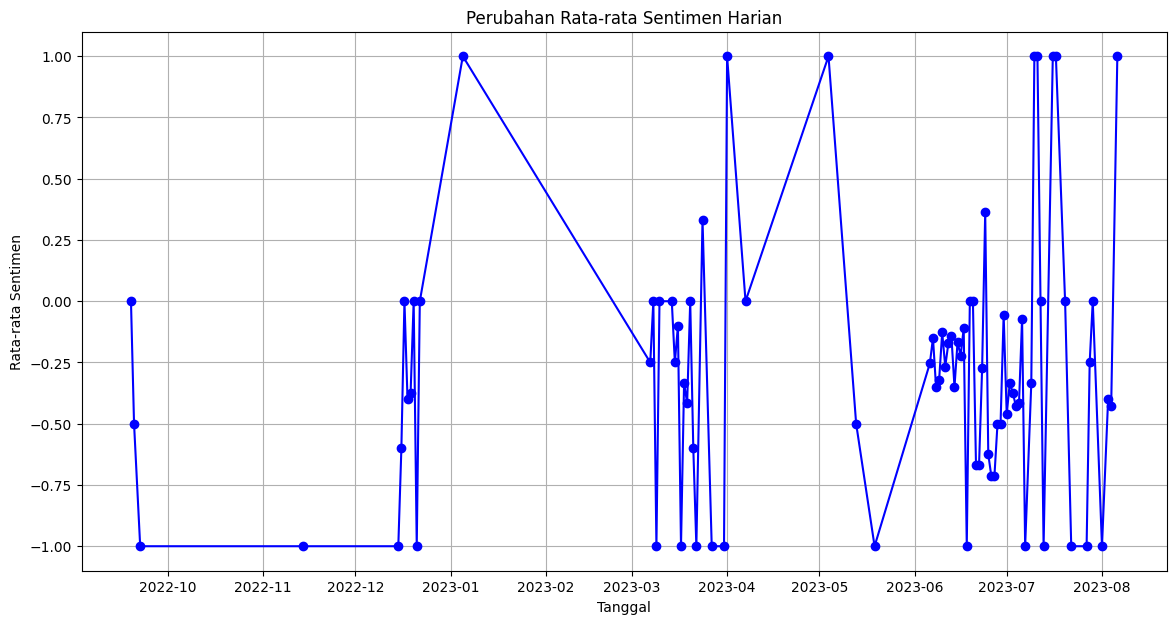

In [49]:
plt.figure(figsize=(14, 7))
harian_avg_sentimen.plot(marker='o', linestyle='-', color='b')
plt.title('Perubahan Rata-rata Sentimen Harian')
plt.xlabel('Tanggal')
plt.ylabel('Rata-rata Sentimen')
plt.grid(True)
plt.show()

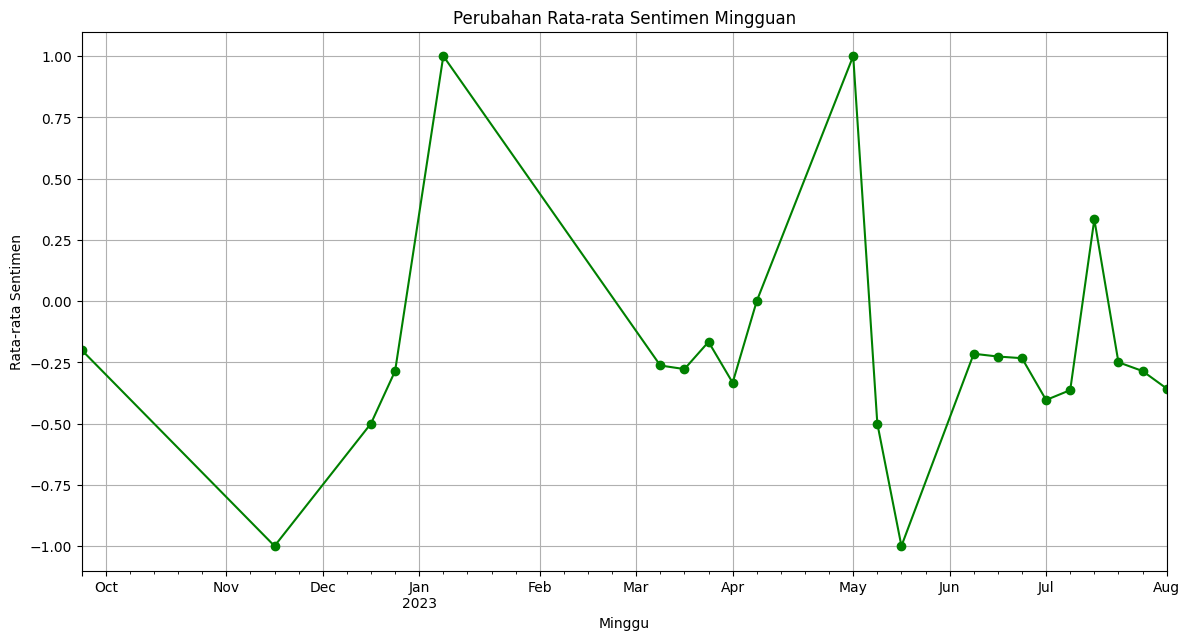

In [50]:
plt.figure(figsize=(14, 7))
mingguan_avg_sentimen.plot(marker='o', linestyle='-', color='g')
plt.title('Perubahan Rata-rata Sentimen Mingguan')
plt.xlabel('Minggu')
plt.ylabel('Rata-rata Sentimen')
plt.grid(True)
plt.show()

# Menghitung Laju Perubahan Sentimen (Sentiment Change Rate)

In [51]:
harian_avg_sentimen_change_rate = harian_avg_sentimen.pct_change().fillna(0)
mingguan_svg_sentimen_change_rate = mingguan_avg_sentimen.pct_change().fillna(0)

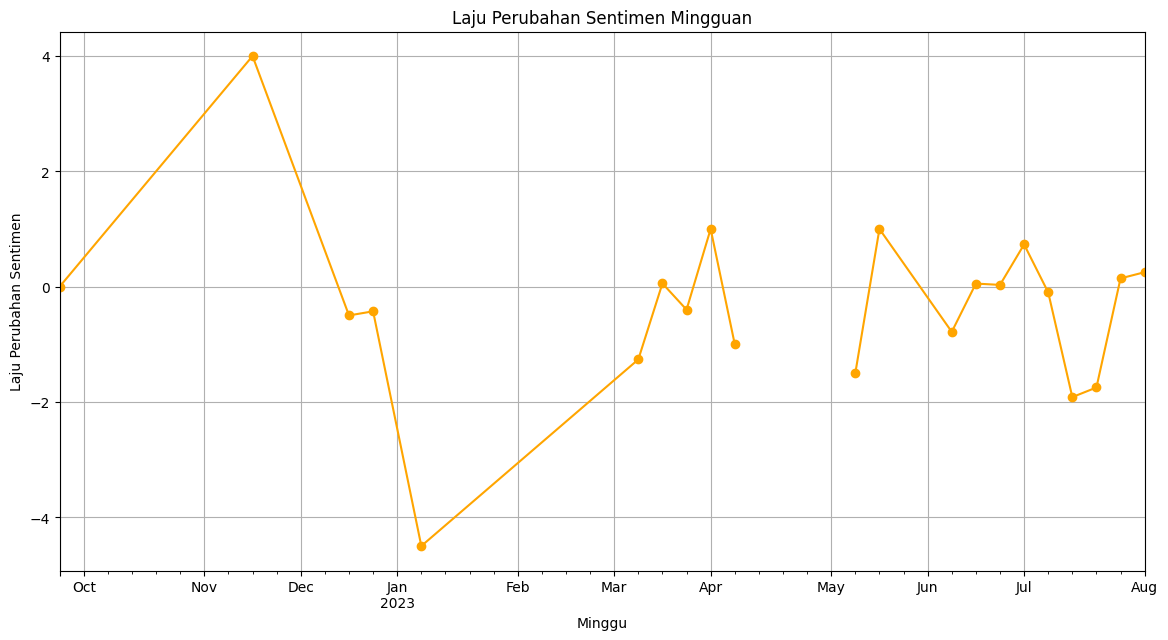

In [52]:
plt.figure(figsize=(14, 7))
mingguan_svg_sentimen_change_rate.plot(marker='o', linestyle='-', color='orange')
plt.title('Laju Perubahan Sentimen Mingguan')
plt.xlabel('Minggu')
plt.ylabel('Laju Perubahan Sentimen')
plt.grid(True)
plt.show()

# Lagged Features
##### Untuk melihat bagaimana sentimen pada hari sebelumnya (atau beberapa hari sebelumnya) mempengaruhi sentimen hari ini.

In [53]:
df=df.sort_values('tanggal')

In [54]:
df['lag_1'] = df['nilai_sentimen'].shift(1)
df['lag_2'] = df['nilai_sentimen'].shift(2)
df['lag_3'] = df['nilai_sentimen'].shift(3)
df['lag_4'] = df['nilai_sentimen'].shift(4)
df['lag_5'] = df['nilai_sentimen'].shift(5)

#### Fitur-fitur lag dibuat menggunakan .shift() untuk melihat sentimen pada hari sebelumnya (lag_1), dua hari sebelumnya (lag_2), dan seterusnya hingga lima hari sebelumnya (lag_5).

In [55]:
df[['tanggal', 'nilai_sentimen', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']].head(10)

,tanggal,nilai_sentimen,lag_1,lag_2,lag_3,lag_4,lag_5
1516,2022-09-19 11:41:32+00:00,-1,NaN,NaN,NaN,NaN,NaN
1515,2022-09-19 11:48:39+00:00,0,-1.0,NaN,NaN,NaN,NaN
1514,2022-09-19 12:23:06+00:00,1,0.0,-1.0,NaN,NaN,NaN
1513,2022-09-19 12:27:18+00:00,-1,1.0,0.0,-1.0,NaN,NaN
1512,2022-09-19 12:30:44+00:00,-1,-1.0,1.0,0.0,-1.0,NaN
1511,2022-09-19 14:47:02+00:00,1,-1.0,-1.0,1.0,0.0,-1.0
1510,2022-09-19 15:53:07+00:00,1,1.0,-1.0,-1.0,1.0,0.0
1509,2022-09-20 05:14:22+00:00,-1,1.0,1.0,-1.0,-1.0,1.0
1508,2022-09-20 15:20:27+00:00,0,-1.0,1.0,1.0,-1.0,-1.0
1507,2022-09-22 22:25:44+00:00,-1,0.0,-1.0,1.0,1.0,-1.0


# Jumlah Aktivitas Per Jam Periode Harian

In [56]:
tahunan = pd.DataFrame(df['jam'].value_counts()).reset_index()
tahunan.columns = ['jam','total_kata']

In [57]:
all_hours = np.arange(0, 24)
tahunan.set_index('jam', inplace=True)
tahunan = tahunan.reindex(all_hours, fill_value=0).reset_index()
tahunan.columns = ['jam', 'total_kata']

fig = go.Figure(go.Bar(
    name="Annual Count", 
    x=tahunan['jam'], 
    y=tahunan['total_kata'], 
    marker=dict(
        color=tahunan['total_kata'], 
        colorscale='Greens', 
        showscale=True  
    )
))

fig.update_layout(
    template='ggplot2', 
    title='Aktivitas User yang Berkomentar Berbasis Jam',
    xaxis_title='Jam', 
    yaxis_title='Total panjang kata komentar',
    xaxis=dict(
        tickmode='array',
        tickvals=np.arange(0, 24),
        ticktext=[str(i) for i in range(0, 24)]
    )
)

fig.show()


# Waktu dalam Sehari yang Paling Banyak Berkomentar

In [58]:
def format_jam(jam: int):
    jam = str(jam)
    if len(jam) == 1: 
        jam = '0' + jam
    jam = jam + ":00"
    return jam

In [59]:
sentimen_positif = df[df['nilai_sentimen'] == 1]
sentimen_netral = df[df['nilai_sentimen'] == 0]
sentimen_negatif = df[df['nilai_sentimen'] == -1]
hourly_positif = sentimen_positif.groupby('jam')['text_cleaning'].count().reset_index()
hourly_positif.columns = ['Jam', "Jumlah Text"]
hourly_positif['Jam'] = hourly_positif['Jam'].apply(format_jam)
hourly_positif['Sentimen'] = 'Positif'
hourly_netral = sentimen_netral.groupby('jam')['text_cleaning'].count().reset_index()
hourly_netral.columns = ['Jam', "Jumlah Text"]
hourly_netral['Jam'] = hourly_netral['Jam'].apply(format_jam)
hourly_netral['Sentimen'] = 'Netral'
hourly_negatif = sentimen_negatif.groupby('jam')['text_cleaning'].count().reset_index()
hourly_negatif.columns = ['Jam', "Jumlah Text"]
hourly_negatif['Jam'] = hourly_negatif['Jam'].apply(format_jam)
hourly_negatif['Sentimen'] = 'Negatif'

hourly_combined = pd.concat([hourly_positif, hourly_netral, hourly_negatif])

fig = px.line_polar(
    data_frame=hourly_combined,
    r='Jumlah Text',
    theta='Jam',
    color='Sentimen',
    line_close=True,
    color_discrete_map={
        'Positif': 'darkgreen',
        'Netral': 'blue',
        'Negatif': 'red'
    },
)

fig.update_layout(
    title="Jam paling aktif berdasarkan sentimen",
    template="ggplot2",
    title_x=0.5,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, hourly_combined['Jumlah Text'].max()]
        ),
    ),
    plot_bgcolor="rgba(240, 240, 240, 1)", 
    paper_bgcolor="rgba(200, 200, 200, 1)", 
)

fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Data Cleaning

In [60]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [61]:
df['text_cleaning_more_clean'] = df['text_cleaning'].apply(lambda x:clean_text(x))

#### Fill Missing Value

In [62]:
df.isnull().sum()

id_komentar                 0
nama_akun                   1
tanggal                     0
text_cleaning               0
sentimen                    0
pemisah_kata                0
total_kata                  0
jam                         0
bulan                       0
tahun                       0
nilai_sentimen              0
lag_1                       1
lag_2                       2
lag_3                       3
lag_4                       4
lag_5                       5
text_cleaning_more_clean    0
dtype: int64

In [63]:
df.fillna(0, inplace=True)

In [64]:
df.isna().sum()

id_komentar                 0
nama_akun                   0
tanggal                     0
text_cleaning               0
sentimen                    0
pemisah_kata                0
total_kata                  0
jam                         0
bulan                       0
tahun                       0
nilai_sentimen              0
lag_1                       0
lag_2                       0
lag_3                       0
lag_4                       0
lag_5                       0
text_cleaning_more_clean    0
dtype: int64

In [65]:
df

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen,pemisah_kata,total_kata,jam,bulan,tahun,nilai_sentimen,lag_1,lag_2,lag_3,lag_4,lag_5,text_cleaning_more_clean
1516,UgyUFUCTdK_RJFsYwQV4AaABAg,La Bold,2022-09-19 11:41:32+00:00,niat beli ev murah malah ikut dinaikin sama pe...,negatif,"[niat, beli, ev, murah, malah, ikut, dinaikin,...",14,11,9,2022,-1,0.0,0.0,0.0,0.0,0.0,niat beli ev murah malah ikut dinaikin sama pe...
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral,"[cerdas, orang, hny, dn, pasar, itu, jln, x, b...",19,11,9,2022,0,-1.0,0.0,0.0,0.0,0.0,cerdas orang hny dn pasar itu jln x blom d...
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif,"[esemka, bangga, solo]",3,12,9,2022,1,0.0,-1.0,0.0,0.0,0.0,esemka bangga solo
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif,"[antar, anak, sekolah, antar, bantu, pasar, kl...",14,12,9,2022,-1,1.0,0.0,-1.0,0.0,0.0,antar anak sekolah antar bantu pasar klw jau...
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif,"[apa, kabar, padahal, negri, luar, biasa, dapa...",8,12,9,2022,-1,-1.0,1.0,0.0,-1.0,0.0,apa kabar padahal negri luar biasa dapat negara
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif,"[syarat, ngaco, woy, anak, muda, blom, punya, ...",27,7,8,2023,-1,1.0,-1.0,-1.0,0.0,-1.0,syarat ngaco woy anak muda blom punya ruma...
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif,"[model, jelek, kwalitas, buruk, harga, mahal, ...",7,8,8,2023,-1,-1.0,1.0,-1.0,-1.0,0.0,model jelek kwalitas buruk harga mahal croot
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif,"[baik, kualitas, kembang, dulu, baik, kualitas...",10,10,8,2023,1,-1.0,-1.0,1.0,-1.0,-1.0,baik kualitas kembang dulu baik kualitas motor...
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif,"[problem, subsidi, kualitas, diturunin, harga,...",15,12,8,2023,-1,1.0,-1.0,-1.0,1.0,-1.0,problem subsidi kualitas diturunin harga dinai...


# Slang Fix

In [66]:
slang_dict = {
    'wong':'manusia',
    'ajah':'saja',
    'woi':'hei',
    'zero':'nol',
    'worth':'bernilai',
    'yo':'ya',
    "yah":'sayang sekali',
    'abis':'habis',
    'ganti':'berganti',
    'malah': 'kenapa begitu',
    'duit': 'uang',
    'mikir': 'berpikir',
    'mending': 'lebih baik',
    'kok': 'mengapa',
    "gak": "tidak",
    "kalo": "kalau",
    "plg": "pulang",
    "pake": "pakai",
    "jt": "juta",
    "cuma": "hanya",
    "kaya": "seperti", 
    "mungkin": "bisa jadi",  
    "bikin": "membuat",  
    "kendara": "kendaraan",  
    "ev": "kendaraan listrik",  
    "bbm": "bahan bakar minyak",  
    "makin": "semakin",
    "batre": "baterai",
    "gimana": "bagaimana",
    "mending": "lebih baik",
    "kayak": "seperti",
    "mikir": "berpikir",
    "tak": "tidak",
    "karna": "karena",
    "blm": "belum",
    "pln": "Perusahaan Listrik Negara",  
    "cm": "centimeter",  
    "jg": "juga",
    "dl": "dulu",
    "banget": "sangat",
    "cas": "mengisi daya",
    "tau": "tahu",
    "ngecas": "mengisi daya",  
    "indo": "Indonesia",       
    "si": "saja",              
    "jd": "jadi",              
    "lingkung": "lingkungan",
    "jln": "jalan",
    "knp" : "kenapa",
    "naikin" : "menaikkan",
    "balik" : "kembali",
    "mantap" : "hebat",
    "segitu" : "seperti itu", 
    "ngecasnya" : "pengisian daya",
    "colok" : "menyambungkan",
    'kudu' : 'harus',
    'cuma' : ' hanya',
    'jabat': 'kedudukan',
    'tri': 'dari',
    'bbm': 'bahan bakar',
    #new
    'insya': 'insyaallah',
    'loh': 'kenapa begitu',
    'laris manis': 'terjual banyak',
    'dinaikin': 'naikkan',
    'usaha': 'cari',
    'gitu': 'seperti itu',
    'emang': 'memang',
    'kwalitas': 'kualitas',
    'mahal': 'tinggi harganya',
    'begitu': 'seperti itu',
    'yakin': 'percaya',
    'dong': 'jangan',
    'belum': 'tidak',
    'banget': 'sangat',
    'bikin': 'buat',
    'merasa': 'perasaan',
    'punya': 'milik',
    'mau': 'ingin',
    'tambah': 'lebih',
    'jual': 'menjual',
    'benar': 'tepat',
    'cuma': 'hanya',
    'sedikit': 'kecil',
    'jangan': 'tidak',
    'dikit': 'sedikit',
    'yuk': 'ayo',
    'kayaknya': 'sepertinya',
    'pake': 'pakai',
    'oke': 'baik',
    'nih': 'ini',
    'bentar': 'sebentar',
    'btw': 'omong omong',
    'gue': 'saya',
    'kenapa': 'mengapa',
    'aja': 'saja',
    'gitu': 'begitu',
    'kecewa': 'tidak puas',
    'keren': 'hebat',
    'udah': 'sudah',
    'liat': 'lihat',
    'cepet': 'cepat',
    'moga': 'semoga',
    'smoga': 'semoga',
    'so': 'jadi',
    'pas': 'tepat',
    'nanya': 'bertanya',
    'parah': 'sangat buruk',
    'ya': 'iya',
    'nyampe': 'sampai',
    'nggak': 'tidak',
    'belum': 'tidak',
    'tdk': 'tidak',
    'nih': 'ini',
    'kl': 'kalau',
    'buat': 'untuk',
    'tp': 'tapi',
    'hrs': 'harus',
    'gitu': 'seperti itu',
    'kenapa': 'mengapa',
    'jgn': 'jangan',
    'td': 'tadi',
    'bs': 'bisa',
    'krn': 'karena',
    'gitu': 'seperti itu',
    'mgkn': 'mungkin',
    'bkn': 'bukan',
    'deh': 'sudah',
    'sek': 'sebentar',
    'cewek': 'perempuan',
    'cowok': 'laki-laki',
    'kayak': 'seperti',
    'knp': 'kenapa',
    'thn': 'tahun',
    'th': 'tahun',
    'kapan': 'bila',
    'keren': 'hebat',
    'hape': 'ponsel',
    'capek': 'lelah',
    'gampang': 'mudah',
    'mending': 'lebih baik',
    'omong': 'berbicara',
    'ada': 'punya',
    'pak': 'bapak',
    'ngeri': 'menakutkan',
    'banget': 'sangat',
    'ada': 'punya',
    'ga': 'tidak',
    'hancur': 'rusak',
    'hancurin': 'merusak',
    'kurang': 'tidak cukup',
    'gtu': 'begitu',
    'banget': 'sangat',
    'jgn': 'jangan',
    'td': 'tadi',
    'capek': 'lelah',
    'mending': 'lebih baik',
    'makanya': 'itu sebabnya',
    'jelek': 'buruk',
    'kebawa': 'terbawa',
    'begitu': 'seperti itu',
    'bikin': 'membuat',
    'pengen': 'ingin',
    'kalo': 'kalau',
    'dikit': 'sedikit',
    'temen': 'teman',
    'kebanyakan': 'terlalu banyak',
    'sampe': 'sampai',
    'ngebet': 'berharap',
    'banget': 'sangat',
    'so': 'jadi',
    'klw':'kalau',
    'gitu': 'seperti itu',
    'gak': 'tidak',
    'dah': 'sudah',
    'bilang': 'berkata',
    'ya': 'iya',
    'udah': 'sudah',
    'nyoba': 'mencoba',
    'jgn': 'jangan',
    'aja': 'saja',
    'tau': 'tahu',
    'lho': 'kenapa begitu',
    'beli': 'membeli',
    'ketemu': 'bertemu',
    'hny':'hanya',
    'dn': 'dan',
    'negri' : 'negeri',
    'x' : 'kali',
    'blom':'belum',
    'dlu':'dahulu'
}

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['text_cleaned_final'] = df['text_cleaning_more_clean'].apply(normalize_slang)


### Stopwords NLTK Corpus

In [67]:
def remove_stopword(x):
    if isinstance(x, str):
        x = x.split()
    return [y for y in x if y not in stopwords.words('indonesian')]

In [68]:
df['stopwords_pemisah_kata_cleaned'] = df['text_cleaned_final'].apply(remove_stopword)

In [69]:
df['total_pemisah_kata_stopwords_clean'] = df.stopwords_pemisah_kata_cleaned.apply(len)

In [70]:
df.head(10)

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen,pemisah_kata,total_kata,jam,bulan,tahun,nilai_sentimen,lag_1,lag_2,lag_3,lag_4,lag_5,text_cleaning_more_clean,text_cleaned_final,stopwords_pemisah_kata_cleaned,total_pemisah_kata_stopwords_clean
1516,UgyUFUCTdK_RJFsYwQV4AaABAg,La Bold,2022-09-19 11:41:32+00:00,niat beli ev murah malah ikut dinaikin sama pe...,negatif,"[niat, beli, ev, murah, malah, ikut, dinaikin,...",14,11,9,2022,-1,0.0,0.0,0.0,0.0,0.0,niat beli ev murah malah ikut dinaikin sama pe...,niat membeli kendaraan listrik murah kenapa be...,"[niat, membeli, kendaraan, listrik, murah, nai...",10
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral,"[cerdas, orang, hny, dn, pasar, itu, jln, x, b...",19,11,9,2022,0,-1.0,0.0,0.0,0.0,0.0,cerdas orang hny dn pasar itu jln x blom d...,cerdas orang hanya dan pasar itu jalan kali be...,"[cerdas, orang, pasar, jalan, kali, da, kota, ...",15
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif,"[esemka, bangga, solo]",3,12,9,2022,1,0.0,-1.0,0.0,0.0,0.0,esemka bangga solo,esemka bangga solo,"[esemka, bangga, solo]",3
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif,"[antar, anak, sekolah, antar, bantu, pasar, kl...",14,12,9,2022,-1,1.0,0.0,-1.0,0.0,0.0,antar anak sekolah antar bantu pasar klw jau...,antar anak sekolah antar bantu pasar kalau jau...,"[anak, sekolah, bantu, pasar, jebak, macet, ha...",9
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif,"[apa, kabar, padahal, negri, luar, biasa, dapa...",8,12,9,2022,-1,-1.0,1.0,0.0,-1.0,0.0,apa kabar padahal negri luar biasa dapat negara,apa kabar padahal negeri luar biasa dapat negara,"[kabar, negeri, negara]",3
1511,UgwKV4eNnpvkd6NCePx4AaABAg,Hodijah 1203,2022-09-19 14:47:02+00:00,untung pabrik,positif,"[untung, pabrik]",2,14,9,2022,1,-1.0,-1.0,1.0,0.0,-1.0,untung pabrik,untung pabrik,"[untung, pabrik]",2
1510,UgySm8s230qdRasX0Gt4AaABAg,rizky adhi pradana,2022-09-19 15:53:07+00:00,ingat kerja sama sama musk pertama ketemu ...,positif,"[ingat, kerja, sama, sama, musk, pertama, kete...",12,15,9,2022,1,1.0,-1.0,-1.0,1.0,0.0,ingat kerja sama sama musk pertama ketemu ...,ingat kerja sama sama musk pertama bertemu tan...,"[kerja, musk, bertemu, tangan, bisnis, tuju]",6
1509,Ugzv9ZfJglGNVc_fMAR4AaABAg,0,2022-09-20 05:14:22+00:00,mantap fasilitas beri perintah beli ev dp pu...,negatif,"[mantap, fasilitas, beri, perintah, beli, ev, ...",20,5,9,2022,-1,1.0,1.0,-1.0,-1.0,1.0,mantap fasilitas beri perintah beli ev dp pu...,hebat fasilitas beri perintah membeli kendaraa...,"[hebat, fasilitas, perintah, membeli, kendaraa...",19
1508,UgzU2CeRhffQz4DpTbV4AaABAg,Dadan Koswara,2022-09-20 15:20:27+00:00,bisa produksi angkot desa jauh lebih murah mis...,netral,"[bisa, produksi, angkot, desa, jauh, lebih, mu...",17,15,9,2022,0,-1.0,1.0,1.0,-1.0,-1.0,bisa produksi angkot desa jauh lebih murah mis...,bisa produksi angkot desa jauh lebih murah mis...,"[produksi, angkot, desa, murah, angkot, carry,...",12
1507,Ugy8yXLfnlqtMwrnz3V4AaABAg,Street musician,2022-09-22 22:25:44+00:00,harga murah harga batre muahal mafia komunis t...,negatif,"[harga, murah, harga, batre, muahal, mafia, ko...",26,22,9,2022,-1,0.0,-1.0,1.0,1.0,-1.0,harga murah harga batre muahal mafia komunis t...,harga murah harga baterai muahal mafia komunis...,"[harga, murah, harga, baterai, muahal, mafia, ...",21


In [71]:
df_cleaned = df.copy()

In [72]:
print("Dataset size:", len(df_cleaned))

Dataset size: 1517


In [73]:
df_cleaned[df_cleaned.sentimen == 'negatif'].shape
df_cleaned.shape

(1517, 20)

In [74]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


### Sastrawi Stemmer

In [75]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [76]:
df_cleaned['text_cleaning_stemmed'] = df_cleaned['text_cleaned_final'].apply(
    lambda row: stemmer.stem(row)
)

In [77]:
def stem_tokens(tokens):
    text = ' '.join(tokens)  # gabungk token menjadi string
    stemmed_text = stemmer.stem(text) 
    return stemmed_text.split()  

In [78]:
df_cleaned['text_cleaning_stemmed'] = df_cleaned['stopwords_pemisah_kata_cleaned'].apply(stem_tokens)

In [79]:
df_cleaned

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen,pemisah_kata,total_kata,jam,bulan,tahun,...,lag_1,lag_2,lag_3,lag_4,lag_5,text_cleaning_more_clean,text_cleaned_final,stopwords_pemisah_kata_cleaned,total_pemisah_kata_stopwords_clean,text_cleaning_stemmed
1516,UgyUFUCTdK_RJFsYwQV4AaABAg,La Bold,2022-09-19 11:41:32+00:00,niat beli ev murah malah ikut dinaikin sama pe...,negatif,"[niat, beli, ev, murah, malah, ikut, dinaikin,...",14,11,9,2022,...,0.0,0.0,0.0,0.0,0.0,niat beli ev murah malah ikut dinaikin sama pe...,niat membeli kendaraan listrik murah kenapa be...,"[niat, membeli, kendaraan, listrik, murah, nai...",10,"[niat, beli, kendara, listrik, murah, naik, pe..."
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral,"[cerdas, orang, hny, dn, pasar, itu, jln, x, b...",19,11,9,2022,...,-1.0,0.0,0.0,0.0,0.0,cerdas orang hny dn pasar itu jln x blom d...,cerdas orang hanya dan pasar itu jalan kali be...,"[cerdas, orang, pasar, jalan, kali, da, kota, ...",15,"[cerdas, orang, pasar, jalan, kali, da, kota, ..."
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif,"[esemka, bangga, solo]",3,12,9,2022,...,0.0,-1.0,0.0,0.0,0.0,esemka bangga solo,esemka bangga solo,"[esemka, bangga, solo]",3,"[esemka, bangga, solo]"
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif,"[antar, anak, sekolah, antar, bantu, pasar, kl...",14,12,9,2022,...,1.0,0.0,-1.0,0.0,0.0,antar anak sekolah antar bantu pasar klw jau...,antar anak sekolah antar bantu pasar kalau jau...,"[anak, sekolah, bantu, pasar, jebak, macet, ha...",9,"[anak, sekolah, bantu, pasar, jebak, macet, ha..."
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif,"[apa, kabar, padahal, negri, luar, biasa, dapa...",8,12,9,2022,...,-1.0,1.0,0.0,-1.0,0.0,apa kabar padahal negri luar biasa dapat negara,apa kabar padahal negeri luar biasa dapat negara,"[kabar, negeri, negara]",3,"[kabar, negeri, negara]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif,"[syarat, ngaco, woy, anak, muda, blom, punya, ...",27,7,8,2023,...,1.0,-1.0,-1.0,0.0,-1.0,syarat ngaco woy anak muda blom punya ruma...,syarat ngaco woy anak muda belum milik rumah b...,"[syarat, ngaco, woy, anak, muda, milik, rumah,...",22,"[syarat, ngaco, woy, anak, muda, milik, rumah,..."
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif,"[model, jelek, kwalitas, buruk, harga, mahal, ...",7,8,8,2023,...,-1.0,1.0,-1.0,-1.0,0.0,model jelek kwalitas buruk harga mahal croot,model buruk kualitas buruk harga tinggi hargan...,"[model, buruk, kualitas, buruk, harga, hargany...",7,"[model, buruk, kualitas, buruk, harga, harga, ..."
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif,"[baik, kualitas, kembang, dulu, baik, kualitas...",10,10,8,2023,...,-1.0,-1.0,1.0,-1.0,-1.0,baik kualitas kembang dulu baik kualitas motor...,baik kualitas kembang dulu baik kualitas motor...,"[kualitas, kembang, kualitas, motor, motor, pa...",7,"[kualitas, kembang, kualitas, motor, motor, pa..."
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif,"[problem, subsidi, kualitas, diturunin, harga,...",15,12,8,2023,...,1.0,-1.0,-1.0,1.0,-1.0,problem subsidi kualitas diturunin harga dinai...,problem subsidi kualitas diturunin harga naikk...,"[problem, subsidi, kualitas, diturunin, harga,...",12,"[problem, subsidi, kualitas, diturunin, harga,..."


In [80]:
df_cleaned['day_of_week'] = pd.to_datetime(df_cleaned['tanggal']).dt.dayofweek
df_cleaned['is_weekend'] = df_cleaned['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# TFIDF with SVM

In [81]:
df_cleaned['stopwords_pemisah_kata_cleaned'] = df_cleaned['stopwords_pemisah_kata_cleaned'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(min_df=3, max_df=0.5, ngram_range=(1, 1))
features = tfidf.fit_transform(df_cleaned['stopwords_pemisah_kata_cleaned'].values)
dfuni = pd.DataFrame(features.todense(), columns=tfidf.get_feature_names_out())


In [82]:
encoder = LabelEncoder()
df_cleaned['sentimen_encoded'] = encoder.fit_transform(df_cleaned['sentimen'])

In [83]:
seed = 0
splits = 5
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
tf.keras.utils.set_random_seed(seed)

In [84]:
def cross_validation(model, cv=skf):
    x = dfuni
    y = df_cleaned['sentimen_encoded']
    
    val_predictions = np.zeros((len(x)))
    train_scores, val_scores= [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(x,y)):
        x_train, y_train = x.iloc[train_idx].reset_index(drop=True),y.iloc[train_idx].reset_index(drop=True)
        x_val, y_val = x.iloc[val_idx].reset_index(drop=True), y.iloc[val_idx].reset_index(drop=True)
        
        model_ = clone(model)
        model_.fit(x_train, y_train)
        
        val_preds = model_.predict_proba(x_val).argmax(axis=1)
        val_acc = accuracy_score(y_val, val_preds)
        val_predictions[val_idx] = val_preds

        train_preds = model_.predict_proba(x_train).argmax(axis=1)
        train_acc = accuracy_score(y_train, train_preds)

        val_scores.append(val_acc)
        train_scores.append(train_acc)

        print(f'Fold {fold} val acc {val_acc} | train acc {train_acc}')
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f}')
    
    return val_scores, val_predictions

In [85]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

In [86]:
model = SVC(C= 1.0520849716658263, 
            gamma= 0.1996019998334075, 
            kernel= 'linear', 
            max_iter= 7817, 
            probability=True,
           random_state=seed)

score_list['svc'], oof_list['svc'] = cross_validation(model)

Fold 0 val acc 0.694078947368421 | train acc 0.8293487221764221
Fold 1 val acc 0.6907894736842105 | train acc 0.8367683429513603
Fold 2 val acc 0.7095709570957096 | train acc 0.8509060955518946
Fold 3 val acc 0.6897689768976898 | train acc 0.8220757825370676
Fold 4 val acc 0.6831683168316832 | train acc 0.8369028006589786
Val Score: 0.69348 ± 0.00879 | Train Score: 0.83520 ± 0.00958


### Tokenizer Dengan Keras

In [87]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df_cleaned['text_cleaned_final'])

In [88]:
text_matrix = tokenizer.texts_to_matrix(df_cleaned['text_cleaned_final'])
text_matrix = pd.DataFrame(text_matrix)

# Features Engineering

In [89]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [90]:
features = [
    text_matrix, 
    df_cleaned[['total_kata', 'jam', 'bulan', 'nilai_sentimen', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'day_of_week', 'is_weekend']]
]
df_features = pd.concat(features, axis=1)

In [91]:
numerical_features = ['total_kata', 'nilai_sentimen','jam','bulan']

In [92]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # Leave the text matrix untouched
)

In [93]:
df_cleaned.columns = df_cleaned.columns.astype(str)

In [94]:
df_features = pd.concat(features, axis=1)

df_features.columns = df_features.columns.astype(str)

df_features = preprocessor.fit_transform(df_features)


In [95]:
vocab_size = df_features.shape[1]

#### total kata unik

In [96]:
word_counts = len(tokenizer.word_index)

In [97]:
print(word_counts)

3779


In [98]:
label = pd.get_dummies(df_cleaned['sentimen'])

### Train Test Split

In [99]:
x_train, x_test, y_train, y_test = train_test_split(df_features, label, test_size=0.05, stratify=label, random_state=42)


# Modelling ANN

In [100]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [101]:
BATCH_SIZE = 32
EPOCHS = 10

In [102]:
def create_model_ann_optuna(learning_rate=0.001, dropout_rate=0.3, l2_rate=0.001):
    input_layer = Input(shape=(vocab_size,))
    
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    output_layer = Dense(3, activation='softmax')(x)
    
    model_optuna = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = Adam(learning_rate=learning_rate)
    model_optuna.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model_optuna

In [103]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    l2_rate = trial.suggest_float('l2_rate', 1e-6, 1e-2, log=True)   

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for train_index, val_index in kf.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model_optuna = create_model_ann_optuna(learning_rate=learning_rate, dropout_rate=dropout_rate, l2_rate=l2_rate)

        early_stopping = EarlyStopping(
            monitor='val_accuracy', 
            patience=5, 
            mode='max', 
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_accuracy', 
            factor=0.5, 
            patience=5, 
            mode='max', 
            verbose=1
        )

        history = model_optuna.fit(
            x_train_fold, y_train_fold,
            epochs=EPOCHS,  
            batch_size=BATCH_SIZE,  
            validation_data=(x_val_fold, y_val_fold),
            verbose=1,
            callbacks=[early_stopping, reduce_lr]
        )

        val_accuracy = history.history['val_accuracy'][-1]
        val_accuracies.append(val_accuracy)

    return np.mean(val_accuracies)

In [104]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-09-02 16:57:47,969] A new study created in memory with name: no-name-d9b1aa43-5b81-4bdc-8afe-e10f7341e6e9


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3389 - loss: 1.7697 - val_accuracy: 0.3391 - val_loss: 1.1065 - learning_rate: 4.6022e-05
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3341 - loss: 1.7039 - val_accuracy: 0.3806 - val_loss: 1.0999 - learning_rate: 4.6022e-05
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3693 - loss: 1.6250 - val_accuracy: 0.3875 - val_loss: 1.0938 - learning_rate: 4.6022e-05
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3613 - loss: 1.6416 - val_accuracy: 0.4014 - val_loss: 1.0884 - learning_rate: 4.6022e-05
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3781 - loss: 1.5533 - val_accuracy: 0.4118 - val_loss: 1.0838 - learning_rate: 4.6022e-05
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4081 - loss: 1.4833 - val_accuracy: 0.4256 - val_loss: 1.0798 - learning_rate: 4.6022e-05
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4130 - loss

[I 2024-09-02 16:58:07,314] Trial 0 finished with value: 0.42191224098205565 and parameters: {'learning_rate': 4.6022078491433934e-05, 'dropout_rate': 0.4612809117033764, 'l2_rate': 4.2527201356322323e-05}. Best is trial 0 with value: 0.42191224098205565.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4121 - loss: 1.3492 - val_accuracy: 0.5675 - val_loss: 0.8940 - learning_rate: 0.0022
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8118 - loss: 0.5593 - val_accuracy: 0.5640 - val_loss: 0.8458 - learning_rate: 0.0022
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9141 - loss: 0.3276 - val_accuracy: 0.5709 - val_loss: 0.8232 - learning_rate: 0.0022
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9543 - loss: 0.2076 - val_accuracy: 0.5744 - val_loss: 0.8135 - learning_rate: 0.0022
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9728 - loss: 0.1453 - val_accuracy: 0.6159 - val_loss: 0.7777 - learning_rate: 0.0022
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.0929 - val_accuracy: 0.6367 - val_loss: 0.7520 - learning_rate: 0.0022
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9912 - loss: 0.0625 - val_accuracy:

[I 2024-09-02 16:58:26,261] Trial 1 finished with value: 0.6953503489494324 and parameters: {'learning_rate': 0.00220028825850088, 'dropout_rate': 0.19057395618894804, 'l2_rate': 2.251145078709065e-06}. Best is trial 1 with value: 0.6953503489494324.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3685 - loss: 1.5191 - val_accuracy: 0.3253 - val_loss: 1.1175 - learning_rate: 2.3505e-04
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4594 - loss: 1.2706 - val_accuracy: 0.4464 - val_loss: 1.0756 - learning_rate: 2.3505e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5208 - loss: 1.1023 - val_accuracy: 0.5121 - val_loss: 1.0391 - learning_rate: 2.3505e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5962 - loss: 0.9206 - val_accuracy: 0.5536 - val_loss: 1.0101 - learning_rate: 2.3505e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6299 - loss: 0.8571 - val_accuracy: 0.5813 - val_loss: 0.9822 - learning_rate: 2.3505e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7026 - loss: 0.7364 - val_accuracy: 0.6055 - val_loss: 0.9558 - learning_rate: 2.3505e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7216 - loss

[I 2024-09-02 16:58:45,267] Trial 2 finished with value: 0.628015673160553 and parameters: {'learning_rate': 0.00023505048095669525, 'dropout_rate': 0.242944529630103, 'l2_rate': 3.877101649228664e-06}. Best is trial 1 with value: 0.6953503489494324.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3551 - loss: 1.9279 - val_accuracy: 0.3668 - val_loss: 1.1152 - learning_rate: 7.3096e-05
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3879 - loss: 1.7623 - val_accuracy: 0.4083 - val_loss: 1.0965 - learning_rate: 7.3096e-05
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3996 - loss: 1.6534 - val_accuracy: 0.4637 - val_loss: 1.0791 - learning_rate: 7.3096e-05
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4283 - loss: 1.5977 - val_accuracy: 0.4844 - val_loss: 1.0637 - learning_rate: 7.3096e-05
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4397 - loss: 1.4764 - val_accuracy: 0.5156 - val_loss: 1.0498 - learning_rate: 7.3096e-05
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4450 - loss: 1.4584 - val_accuracy: 0.5225 - val_loss: 1.0355 - learning_rate: 7.3096e-05
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4511 - loss

[I 2024-09-02 16:59:03,088] Trial 3 finished with value: 0.4815599799156189 and parameters: {'learning_rate': 7.309622513860988e-05, 'dropout_rate': 0.44124316032408195, 'l2_rate': 0.00014364832448422545}. Best is trial 1 with value: 0.6953503489494324.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3551 - loss: 1.6245 - val_accuracy: 0.3529 - val_loss: 1.1060 - learning_rate: 1.5293e-04
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3399 - loss: 1.5488 - val_accuracy: 0.4429 - val_loss: 1.0842 - learning_rate: 1.5293e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4188 - loss: 1.4028 - val_accuracy: 0.4810 - val_loss: 1.0636 - learning_rate: 1.5293e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4290 - loss: 1.2617 - val_accuracy: 0.5156 - val_loss: 1.0427 - learning_rate: 1.5293e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4711 - loss: 1.1860 - val_accuracy: 0.5433 - val_loss: 1.0217 - learning_rate: 1.5293e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4696 - loss: 1.1494 - val_accuracy: 0.5709 - val_loss: 1.0026 - learning_rate: 1.5293e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5285 - loss

[I 2024-09-02 16:59:22,087] Trial 4 finished with value: 0.5648524522781372 and parameters: {'learning_rate': 0.00015293027111736357, 'dropout_rate': 0.4413415749296098, 'l2_rate': 5.263162429625164e-05}. Best is trial 1 with value: 0.6953503489494324.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3554 - loss: 1.6924 - val_accuracy: 0.4740 - val_loss: 1.1022 - learning_rate: 3.0862e-04
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3883 - loss: 1.5064 - val_accuracy: 0.5709 - val_loss: 1.0676 - learning_rate: 3.0862e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4344 - loss: 1.3587 - val_accuracy: 0.6228 - val_loss: 1.0384 - learning_rate: 3.0862e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5080 - loss: 1.1750 - val_accuracy: 0.6505 - val_loss: 1.0123 - learning_rate: 3.0862e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5141 - loss: 1.0621 - val_accuracy: 0.6713 - val_loss: 0.9842 - learning_rate: 3.0862e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6080 - loss: 0.8844 - val_accuracy: 0.6886 - val_loss: 0.9598 - learning_rate: 3.0862e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6246 - loss

[I 2024-09-02 16:59:41,427] Trial 5 finished with value: 0.6515955448150634 and parameters: {'learning_rate': 0.00030862026654510414, 'dropout_rate': 0.48893854964763994, 'l2_rate': 0.0009128958362070846}. Best is trial 1 with value: 0.6953503489494324.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4499 - loss: 1.3221 - val_accuracy: 0.5813 - val_loss: 0.9148 - learning_rate: 0.0039
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.6791 - val_accuracy: 0.5744 - val_loss: 0.8477 - learning_rate: 0.0039
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8669 - loss: 0.4355 - val_accuracy: 0.5744 - val_loss: 0.8285 - learning_rate: 0.0039
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9029 - loss: 0.3307 - val_accuracy: 0.6159 - val_loss: 0.8125 - learning_rate: 0.0039
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9260 - loss: 0.2525 - val_accuracy: 0.6436 - val_loss: 0.7871 - learning_rate: 0.0039
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9396 - loss: 0.2133 - val_accuracy: 0.6609 - val_loss: 0.7619 - learning_rate: 0.0039
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.1491 - val_accuracy:

[I 2024-09-02 16:59:59,897] Trial 6 finished with value: 0.7008770823478698 and parameters: {'learning_rate': 0.003881594801598862, 'dropout_rate': 0.44353031060472015, 'l2_rate': 0.0001801919515170194}. Best is trial 6 with value: 0.7008770823478698.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3443 - loss: 1.7573 - val_accuracy: 0.6021 - val_loss: 1.1209 - learning_rate: 0.0013
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5630 - loss: 1.0428 - val_accuracy: 0.5779 - val_loss: 1.0394 - learning_rate: 0.0013
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7187 - loss: 0.8266 - val_accuracy: 0.5779 - val_loss: 0.9939 - learning_rate: 0.0013
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7725 - loss: 0.6863 - val_accuracy: 0.5813 - val_loss: 0.9589 - learning_rate: 0.0013
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8425 - loss: 0.5753 - val_accuracy: 0.5882 - val_loss: 0.9319 - learning_rate: 0.0013
Epoch 6/10
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8866 - loss: 0.4854
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006688603316433728.
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8856 - loss: 0.4831 - val_accuracy: 

[I 2024-09-02 17:00:18,799] Trial 7 finished with value: 0.6537533521652221 and parameters: {'learning_rate': 0.001337720648243515, 'dropout_rate': 0.4932995853944294, 'l2_rate': 0.004812106941433061}. Best is trial 6 with value: 0.7008770823478698.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3454 - loss: 1.4930 - val_accuracy: 0.5813 - val_loss: 1.0142 - learning_rate: 7.3051e-04
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5687 - loss: 0.9318 - val_accuracy: 0.6332 - val_loss: 0.9538 - learning_rate: 7.3051e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6919 - loss: 0.6901 - val_accuracy: 0.6159 - val_loss: 0.9118 - learning_rate: 7.3051e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8126 - loss: 0.5460 - val_accuracy: 0.6090 - val_loss: 0.8738 - learning_rate: 7.3051e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.4123 - val_accuracy: 0.6159 - val_loss: 0.8434 - learning_rate: 7.3051e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.3286 - val_accuracy: 0.6367 - val_loss: 0.8127 - learning_rate: 7.3051e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9524 - loss

[I 2024-09-02 17:00:38,643] Trial 8 finished with value: 0.6918757081031799 and parameters: {'learning_rate': 0.0007305143907812823, 'dropout_rate': 0.1825458393530207, 'l2_rate': 1.7836241129749336e-06}. Best is trial 6 with value: 0.7008770823478698.


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3478 - loss: 1.6696 - val_accuracy: 0.5502 - val_loss: 1.0192 - learning_rate: 0.0011
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5729 - loss: 1.0159 - val_accuracy: 0.5779 - val_loss: 0.9467 - learning_rate: 0.0011
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6942 - loss: 0.7216 - val_accuracy: 0.5848 - val_loss: 0.9064 - learning_rate: 0.0011
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7775 - loss: 0.5923 - val_accuracy: 0.5779 - val_loss: 0.8712 - learning_rate: 0.0011
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8244 - loss: 0.5050 - val_accuracy: 0.5986 - val_loss: 0.8429 - learning_rate: 0.0011
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8863 - loss: 0.3896 - val_accuracy: 0.6194 - val_loss: 0.8184 - learning_rate: 0.0011
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8991 - loss: 0.3329 - val_accuracy:

[I 2024-09-02 17:00:57,205] Trial 9 finished with value: 0.6891123652458191 and parameters: {'learning_rate': 0.0010554173003860165, 'dropout_rate': 0.43695907376043863, 'l2_rate': 2.130434339127688e-06}. Best is trial 6 with value: 0.7008770823478698.


In [105]:
print(f"Best: {study.best_value} using {study.best_params}")

Best: 0.7008770823478698 using {'learning_rate': 0.003881594801598862, 'dropout_rate': 0.44353031060472015, 'l2_rate': 0.0001801919515170194}


In [106]:
best_params = study.best_params
model_optuna = create_model_ann_optuna(learning_rate=best_params['learning_rate'], 
                     dropout_rate=best_params['dropout_rate'],
                     l2_rate=best_params['l2_rate'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

history = model_optuna.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4111 - loss: 1.3543 - val_accuracy: 0.5789 - val_loss: 0.8522
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.6390 - val_accuracy: 0.5789 - val_loss: 0.8247
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - loss: 0.5168 - val_accuracy: 0.6316 - val_loss: 0.7817
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8773 - loss: 0.3473 - val_accuracy: 0.6711 - val_loss: 0.7283
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8997 - loss: 0.2819 - val_accuracy: 0.7763 - val_loss: 0.6358
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9337 - loss: 0.2412 - val_accuracy: 0.7895 - val_loss: 0.6189
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - loss: 0.1881 - val_accuracy: 0.7237 - val_loss: 0.6588
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.1599 - val_accuracy: 0.7763 - val_loss:

In [107]:
predictions = model_optuna.predict(x_test, batch_size=BATCH_SIZE)
predicted_classes = np.argmax(predictions, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [108]:
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

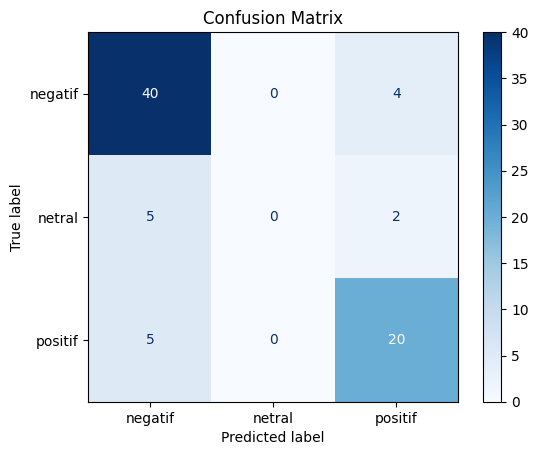

In [109]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#### Evaluate

In [110]:
result_optuna = model_optuna.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {result_optuna[0]:.4f}, Test Accuracy: {result_optuna[1]:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7775 - loss: 0.6348 
Test Loss: 0.6189, Test Accuracy: 0.7895


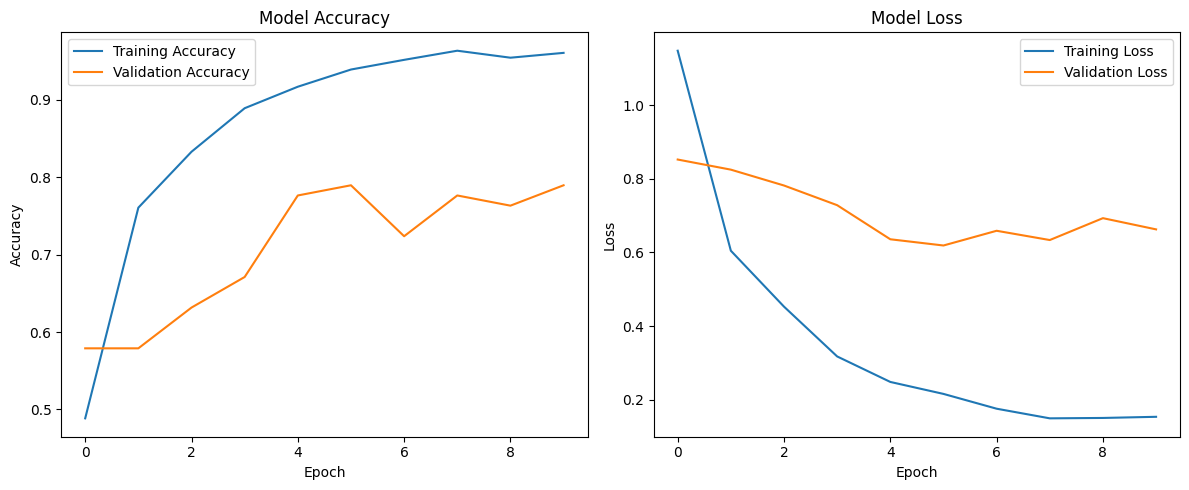

In [111]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
